In [1]:
import pandas as pd
import scipy
import numpy as np
import scipy.sparse as sp
import scipy.io as spio

from scipy.stats import pearsonr, spearmanr

import operator
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter
from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.collections as collections

import isolearn.io as isoio

from apa_variant_prediction_utils import *

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score


In [2]:
#Variant data parameters

isoform_pseudo_count = 1.
proximal_start = 57
proximal_end = 107

file_prefix = "intronic_pa_" + str(proximal_start) + "_" + str(proximal_end)


In [3]:
#Load variant dataframe
seq_dict = isoio.load('../data/prepared_data/apa_array_data/apa_array_data_master_seq')
variant_dict = isoio.load('../data/prepared_data/apa_variant_data/apa_variant_data_master_seq')
print("n (variants) = " + str(len(variant_dict['variant_df'])))

#Load predictions
model_name = 'aparent_theano_legacy_30_31_34_pasaligned'
pred_dict = isoio.load('predictions/apa_array_data_legacy/' + model_name + '_predictions_master_seq')

#Join mpra dataframes with prediction table and calculate cut probabilities
seq_df_aparent, variant_df_aparent = append_predictions(seq_dict['array_df'], seq_dict['pooled_cuts'], variant_dict['variant_df'], variant_dict['pooled_cuts_var'], variant_dict['pooled_cuts_ref'], pred_dict['array_df'], pred_dict['cut_prob'], proximal_start=proximal_start, proximal_end=proximal_end, isoform_pseudo_count=isoform_pseudo_count)


n (variants) = 21734


In [4]:
#Load variant dataframe
seq_dict = isoio.load('../data/prepared_data/apa_array_data/apa_array_data_master_seq')
variant_dict = isoio.load('../data/prepared_data/apa_variant_data/apa_variant_data_master_seq')
print("n (variants) = " + str(len(variant_dict['variant_df'])))

#Load predictions (Resnet)
model_name = 'aparent_all_libs_resnet_no_human_ep_4_tuned'
pred_dict = isoio.load('predictions/apa_array_data_legacy/' + model_name + '_predictions_master_seq')

pred_dict['cut_prob'] = pred_dict['cut_prob'][:, 20:]

#Join mpra dataframes with prediction table and calculate cut probabilities
seq_df_aparent_resnet, variant_df_aparent_resnet = append_predictions(seq_dict['array_df'], seq_dict['pooled_cuts'], variant_dict['variant_df'], variant_dict['pooled_cuts_var'], variant_dict['pooled_cuts_ref'], pred_dict['array_df'], pred_dict['cut_prob'], proximal_start=proximal_start, proximal_end=proximal_end, isoform_pseudo_count=isoform_pseudo_count)


n (variants) = 21734


In [5]:
#Get filtered intronic PA df

intronic_df = seq_df_aparent.query("variant == 'wt' and experiment == 'intronic_pas'")
intronic_df_filtered = seq_df_aparent.query("variant == 'wt' and mean_total_count >= 200 and n_barcodes >= 7 and experiment == 'intronic_pas'")


In [6]:
#Print stats

print("Unfiltered intronic PA df stats:")

print("n sequences = " + str(len(intronic_df)))
print("median pooled read count = " + str(int(np.median(intronic_df['pooled_total_count']))))
print("median n barcodes = " + str(int(np.median(intronic_df['n_barcodes']))))

print("")

print("Filtered intronic PA df stats:")

print("n sequences = " + str(len(intronic_df_filtered)))
print("median pooled read count = " + str(int(np.median(intronic_df_filtered['pooled_total_count']))))
print("median n barcodes = " + str(int(np.median(intronic_df_filtered['n_barcodes']))))


Unfiltered intronic PA df stats:
n sequences = 12521
median pooled read count = 3181
median n barcodes = 8

Filtered intronic PA df stats:
n sequences = 9800
median pooled read count = 3650
median n barcodes = 9


In [ ]:
'''
Example sequences:

AAACCATGGTCACAACACAAGCATAATGTGGGAGGTCATTTTATTTTTACAATAAACACTTTGAGCCTCTGCTTCCTCATGTGTAACACGGACTGTTTACCTCTTCTCTCCTACTGTTTGTCTCCAAAAGTTGCTAATGGGATCACGTAAGAATAGTAACTATG
AGCATAGATTTTTCTTATATTATTTTACTGTTCATAGTGGTAAAAAATCAATTAAAGAGAAATTATCTTTCAGTCTCAGTGAGGAAGGTGTCTTCATGCAGCCAGCAAAAGTCTGCTGTAAAACACTGGGTTCACGGAGGCTTTTCAATGATGGGACATGATGG
TGTTAATTTATCAAATAACTACTTTTGGCTTTGTTTCATTTTTATTATACAATAAAATGAAATTCTTTTCATTGTATTTCTTTTCATTGATTATTCCTATAATTCTTAAACAACTTTATAATTGATGTAACAATAACCTGTACACATTTAAAGTGTAAAATTTA
'''

<h2>Absolute isoform predictions of Native Human pA sites</h2>

aparent-resnet
intronic_pas = 9800


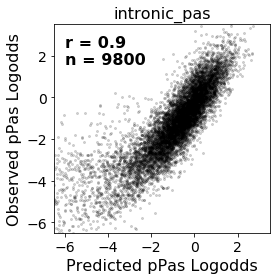

aparent
intronic_pas = 9800


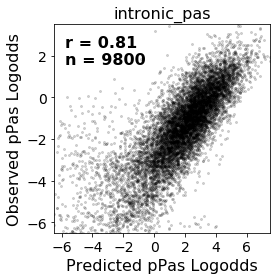

In [28]:
#Absolute native predictions, split by experiment

save_figs = True

seq_dfs = [seq_df_aparent_resnet, seq_df_aparent]

save_names = ['aparent-resnet', 'aparent']

pred_columns = ['logodds_pred_from_cuts', 'mean_logodds_pred']
true_columns = ['logodds_true', 'logodds_true']

x_ranges = [[-6.5, 3.5], [-6.5, 7.5]]

for seq_df, save_name, pred_column, true_column, x_range in zip(seq_dfs, save_names, pred_columns, true_columns, x_ranges) :

    print(save_name)
    
    for experiment in ['intronic_pas'] :

        filter_query = "variant == 'wt' and mean_total_count >= 200 and n_barcodes >= 7 and experiment == '" + str(experiment) + "'"
        experiment_seq_predicted_isoform_df = seq_df.query(filter_query)

        logodds_true_is_nan = (np.isnan(experiment_seq_predicted_isoform_df[true_column]) | np.isinf(experiment_seq_predicted_isoform_df[true_column]))
        logodds_pred_is_nan = (np.isnan(experiment_seq_predicted_isoform_df[pred_column]) | np.isinf(experiment_seq_predicted_isoform_df[pred_column]))
        experiment_seq_predicted_isoform_df = experiment_seq_predicted_isoform_df.loc[(logodds_true_is_nan == False) & (logodds_pred_is_nan == False)]

        print(experiment + ' = ' + str(len(experiment_seq_predicted_isoform_df)))

        #Logodds proportions

        #r_val, _ = pearsonr(experiment_seq_predicted_isoform_df[pred_column], experiment_seq_predicted_isoform_df[true_column])
        r_val, _ = spearmanr(experiment_seq_predicted_isoform_df[pred_column], experiment_seq_predicted_isoform_df[true_column])
        
        f = plt.figure(figsize=(4, 4))

        plt.scatter(experiment_seq_predicted_isoform_df[pred_column], experiment_seq_predicted_isoform_df[true_column], alpha=0.15, s=4, c='black')

        annot_text = 'r = ' + str(round(r_val, 2))
        annot_text += '\nn = ' + str(len(experiment_seq_predicted_isoform_df))
        ax = plt.gca()
        ax.text(0.05, 0.95, annot_text, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, color='black', fontsize=16, weight="bold")

        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        
        plt.xlim(x_range[0], x_range[1])
        plt.ylim(-6.5, 3.5)

        plt.xlabel('Predicted pPas Logodds', fontsize=16)
        plt.ylabel('Observed pPas Logodds', fontsize=16)
        plt.title(experiment, fontsize=16)

        plt.tight_layout()

        if save_figs :
            plt.savefig(save_name + '_' + file_prefix + '_absolute_usage_pred_vs_true_' + experiment + '.png', transparent=True, dpi=150)
            plt.savefig(save_name + '_' + file_prefix + '_absolute_usage_pred_vs_true_' + experiment + '.eps')

        plt.show()
